In [1]:
# To run with multiple threads, see https://github.com/JuliaLang/IJulia.jl#installing-additional-julia-kernels
using Base.Threads
println("Running on $(nthreads()) threads")

using Circulation
using GPFields

using LinearAlgebra

Running on 1 threads


In [2]:
const DATA_DIR_BASE = let dir = expanduser("~/Dropbox/circulation/data")
    @show readdir(dir)
    joinpath(dir, "4vortices")
end

const DATA_IDX = 1
const RESOLUTION = 256

const GP_PARAMS = ParamsGP(
    (RESOLUTION, RESOLUTION),
    c = 1.0,
    nxi = 1.5,
)

let dir = joinpath(DATA_DIR_BASE, string(RESOLUTION))
    println("Directories in $DATA_DIR_BASE: ", readdir(DATA_DIR_BASE))
    println("Files in $dir: ", readdir(dir))
end

readdir(dir) = ["4vortices", "KW", "TG", "TG2D", "rotation", "tangle"]
Directories in /home/jipolanco/Dropbox/circulation/data/4vortices: ["1024", "128", "256", "512"]
Files in /home/jipolanco/Dropbox/circulation/data/4vortices/256: ["ImaPsi.001.dat", "ReaPsi.001.dat", "tt.001.dat"]


In [3]:
# Load data
psi = let datadir = joinpath(DATA_DIR_BASE, string(GP_PARAMS.dims[1]))
    @show datadir
    @time GPFields.load_psi(GP_PARAMS, datadir, DATA_IDX)
end
summary(psi)

datadir = "/home/jipolanco/Dropbox/circulation/data/4vortices/256"
  0.044592 seconds (6.63 k allocations: 1.324 MiB)


"256×256 Array{Complex{Float64},2}"

In [4]:
rho = GPFields.compute_density(psi)
summary(rho)

"256×256 Array{Float64,2}"

In [5]:
p = GPFields.compute_momentum(psi, GP_PARAMS);
v = map(pj -> pj ./ (rho .+ 1e-12), p);
vreg = map(pj -> pj ./ sqrt.(rho), p);
@show extrema(p[1]);
@show extrema(v[1]);
@show extrema(vreg[1]);

extrema(p[1]) = (-0.45814510622314997, 0.4581451062231484)
extrema(v[1]) = (-2.1214136716727605, 2.1214136716737384)
extrema(vreg[1]) = (-0.8209650151506064, 0.7803450032469096)


In [6]:
Ls = GP_PARAMS.L
Ip = IntegralField2D(p[1], L=Ls);
@time prepare!(Ip, v);

  0.222213 seconds (431.59 k allocations: 21.969 MiB)


In [7]:
using BenchmarkTools

Ns = GP_PARAMS.dims
κ = GP_PARAMS.κ

# Make loop around (Nx/4, Ny/4)
I0 = Ns .>> 2  # N / 2^2 = N / 4
dI = Ns .>> 6  # N / 2^6 = N / 64
loop = Circulation.Rectangle(I0 .- dI, 2 .* dI)

# In physical coordinates
loop_phys = (Ls ./ Ns) * loop

println(loop)
println(loop_phys)

circulation(loop, Ip) / κ

Rectangle of size (8, 8) centred at (64.0, 64.0)
Rectangle of size (0.19634954084936207, 0.19634954084936207) centred at (1.5707963267948966, 1.5707963267948966)


-1.000005171254113

In [8]:
# Compute full circulation from regularised velocity
loop_length = 12
circ = similar(v[1]) :: Matrix
loop_dims = (loop_length, loop_length)

@time prepare!(Ip, vreg)  # compute integral field w(x, y)

circulation!(circ, Ip, loop_dims)   # precompilation (not needed, but for accurate timings...)
@time circulation!(circ, Ip, loop_dims);  # compute circulation

@show norm(circ)

# @btime circulation!($circ, $Ip, $loop_dims);

  0.003283 seconds
  0.004602 seconds
norm(circ) = 6.613718940346879


# Plots

In [9]:
@time import PyPlot
const plt = PyPlot;

  5.941644 seconds (7.03 M allocations: 354.675 MiB, 4.53% gc time)


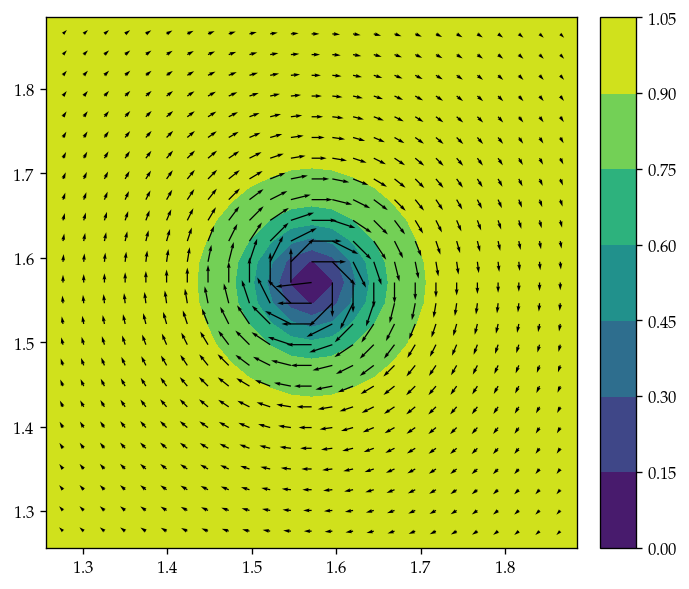

(1.2566370614359172, 1.8849555921538759)

In [13]:
fig, ax = plt.subplots(dpi=120)
figlims = (0.4pi, 0.6pi)
x, y = get_coordinates(GP_PARAMS)
ax.set_aspect(:equal)
cf = ax.contourf(x, y, rho')
# cf = ax.contourf(x, y, v[1])
fig.colorbar(cf)
ax.quiver(x, y, vreg[1]', vreg[2]', scale=12)
# ax.quiver(x, y, v[2]', v[1]', scale=15)
ax.set_xlim(figlims...)
ax.set_ylim(figlims...)

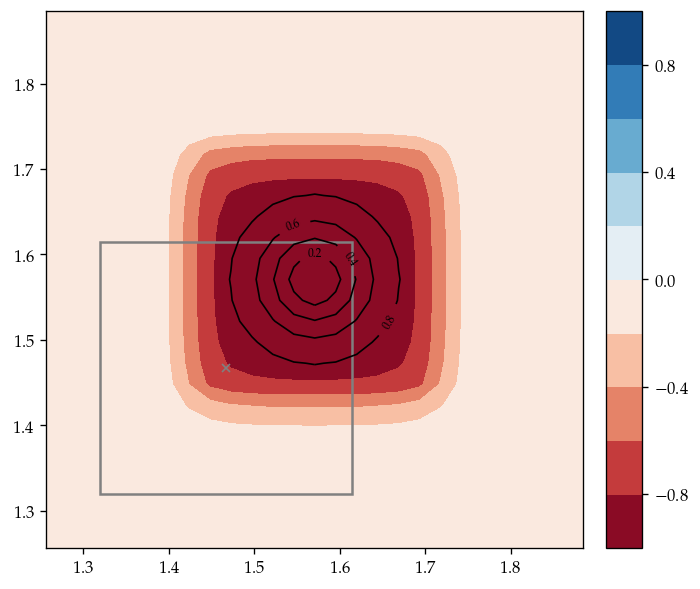

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f379e7c6550>

In [15]:
fig, ax = plt.subplots(dpi=120)
ax.set_aspect(:equal)
cf = ax.contourf(x, y, circ' ./ κ, levels=11, cmap=plt.cm.RdBu)
# cf = ax.contourf(x, y, v[1])
fig.colorbar(cf)

# ax.quiver(x, y, p[1]', p[2]', scale=12)
# ax.quiver(x, y, v[2]', v[1]', scale=15)

ax.set_xlim(figlims...)
ax.set_ylim(figlims...)

ct = ax.contour(x, y, rho', levels=0:0.2:1, linewidths=1, colors=:black)
ax.clabel(ct, inline=true, fontsize="x-small", fmt="%.1f")

# Draw a single rectangle
kwargs = (color=:grey, lw=1.5, )
dx = GP_PARAMS.L ./ GP_PARAMS.dims
loop = Circulation.Rectangle((0, 0), loop_dims) * dx + (0.42pi, 0.42pi)
xc = Circulation.get_centre(loop)
rect = plt.matplotlib.patches.Rectangle(loop.x, loop.r...; fill=false, kwargs...)
ax.add_patch(rect)
ax.plot(xc...; marker=:x, markersize=5, kwargs...)  # rectangle centre

# VTK files (for verification)

In [12]:
using WriteVTK

vtk_grid("fields", x, y, compress=false) do vtk
    vtk["rho"] = rho
    vtk["v"] = v
    vtk["v_reg"] = vreg
    vtk["p"] = p
    vtk["circ"] = circ
end

1-element Array{String,1}:
 "fields.vti"